# IGC example
## Simulation data generation
5 signals of normal distribution with one connectivity (0->3)  
Noise (0.2 times) is added

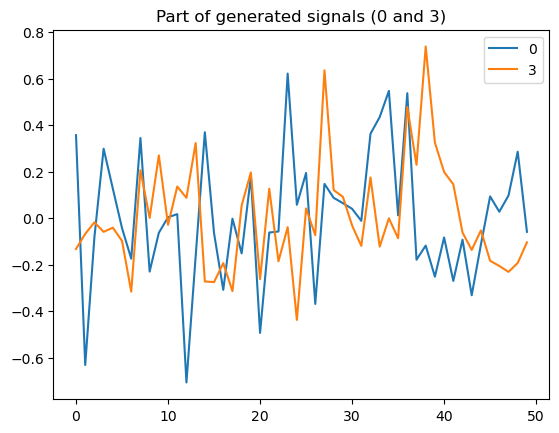

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import IGC

# Simulate [0 -> 3] connectivity signals
x, weights = IGC.simulate_data_random(5, [[0,3],], 0.2, order=5, nonlinear=False, fixed_weight=False, sn=10000)
# Add random signals for statistical inference
nrs=int(np.ceil(x.shape[-1]*.4))
x = torch.cat([x, torch.randn(x.shape[0], nrs)], axis=1)
# Normalization of input data
for i in range(x.shape[1]):
    x[:,i]=(x[:,i]-torch.mean(x[:,i]))/torch.std(x[:,i])/3.0
plt.plot(x[:50,[0,3]])
plt.title('Part of generated signals (0 and 3)')
plt.legend(['0', '3'])
plt.show()
# Reconstruction of a dataset with (order) time steps (ex: 20)
x_train, y_train = IGC.multivariate_data(x, x, 0, int(x.shape[0]*0.8), 10, 1, 1, True)
x_test, y_test = IGC.multivariate_data(x, x, int(x.shape[0]*0.8), int(x.shape[0]), 10, 1, 1, True)
x_train = x_train.float()
y_train = y_train.float()
x_test = x_test.float()
y_test = y_test.float()

## Model construction
One bidirectional LSTM layer and two dense layers  
The last layer is the output layer  
Model training  
&emsp;- 50 iterations with early stopping  
&emsp;- Adam optimization  
&emsp;- learning rate=0.001  
&emsp;- minibatch size = 100  
Please note that total correlation coefficient can be small because the model can not predict unrelated signals.  
Under the condition where 0 causes 3, the prediction of signal 3 is accurate with prior information of signal 0.

Epoch [1/50]  Train_loss: 0.13239  Test_loss: 0.10237  Elapsed: 0.525s
Epoch [2/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [3/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [4/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [5/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [6/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [7/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [8/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [9/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [10/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [11/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [12/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [13/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
Epoch [14/50]  Train_loss: 0.00000  Test_loss: 0.10237  Elapsed: 0.000s
E

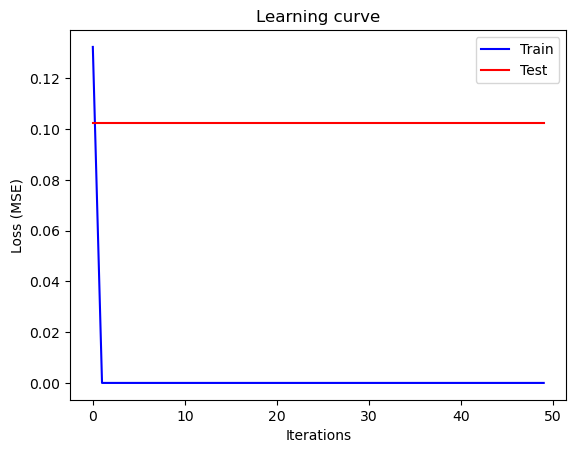

In [5]:
device="cuda:0"
# Build a predefined model and train
model = IGC.MVAR_biLSTM(x.shape[-1], 200, 1, x.shape[-1]).to(device)
trainhist, testhist = IGC.train_model(model, (x_train, y_train), (x_test, y_test), 
                                      50, lr=0.001, n_batch=100, device=device)
train_corr=IGC.evaluation_corr(model, (x_train, y_train))
test_corr=IGC.evaluation_corr(model, (x_test, y_test))
print('Total correlation coefficients.\n\tTrain: %5.3f\n\tTest: %5.3f' %(train_corr[0], test_corr[0]))
print('Evaluation of signal 0 and 3')
print('Train corr: (%5.3f, %5.3f), Test corr: (%5.3f, %5.3f)' %(train_corr[1][0], train_corr[1][3], 
                                                                test_corr[1][0], test_corr[1][3]))
plt.plot(trainhist,'b', label='Train')
plt.plot(testhist,'r', label='Test')
plt.title('Learning curve')
plt.xlabel('Iterations')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## Integrated Gradients Connectivity (IGC) with non-parametric statistics
Use IGC functions

..................................................
50 gradients were collected
..................................................
50 gradients were collected


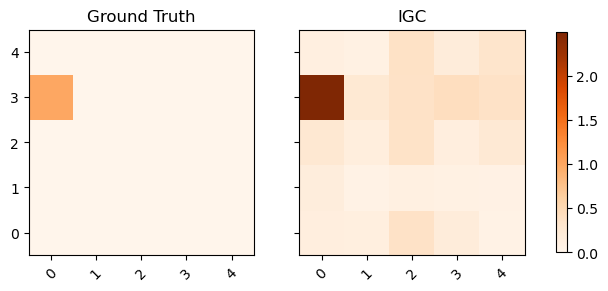

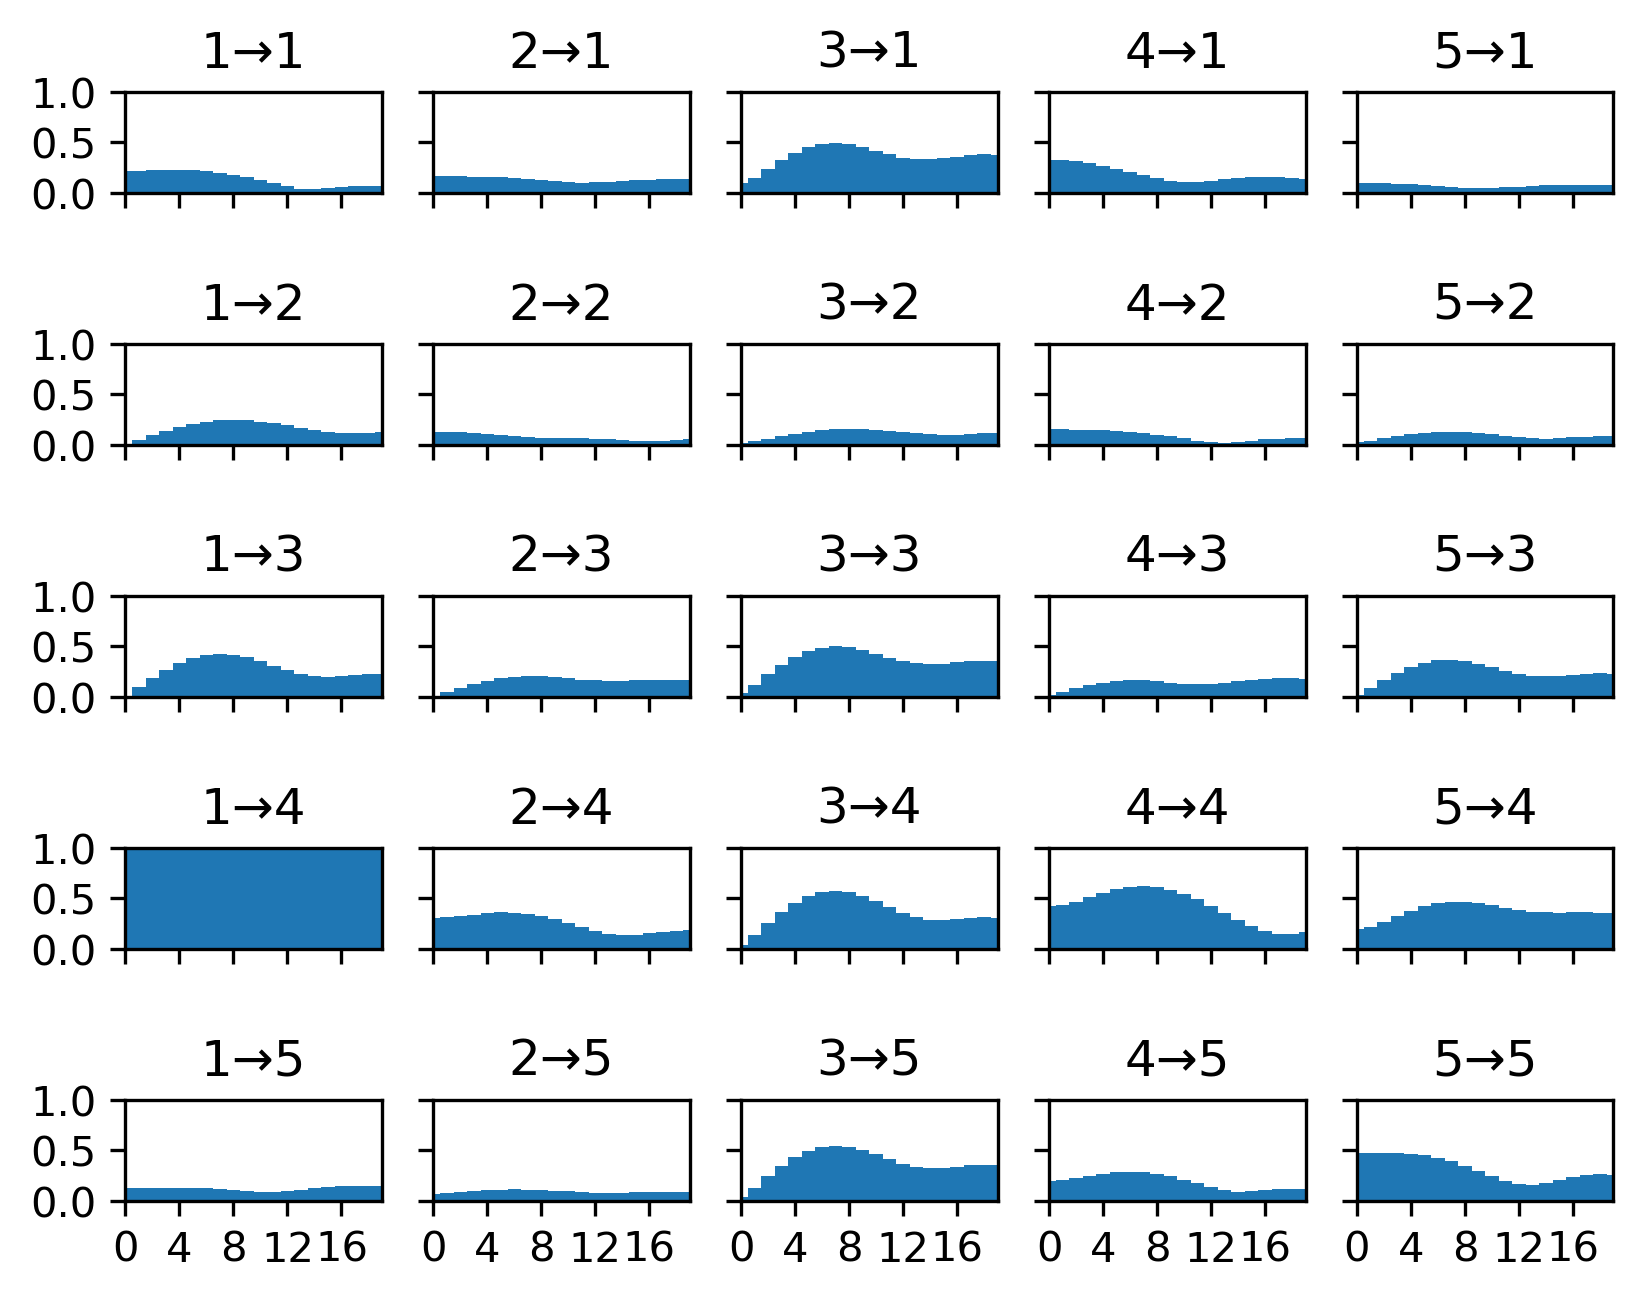

In [8]:
groundtruth=torch.zeros((5,5))
groundtruth[3,0]=1
igc, cl, igc_t, igc_p, igc_f, igc_o, foi = IGC.ig_connectivity(x, model=model, nrs=nrs, device=device)
IGC.display_connectivity([groundtruth, igc], title=['Ground Truth', 'IGC'], 
                         labels=['0','1','2','3','4'], vmax=igc.max())
fig=IGC.display_conn_spectrum(igc_f)

## Integrated Gradients Connectivity (IGC) with DTF & PDC normalization
Use IGC functions.  
In this example, the model for non-parametric statistics was reused. With the addition of two random signals, the number of model's inputs increase from the original five to two, for a total of seven input features.
However, PDC or DTF-like normalization does not need additional random signals.

..................................................
50 gradients were collected
..................................................
50 gradients were collected


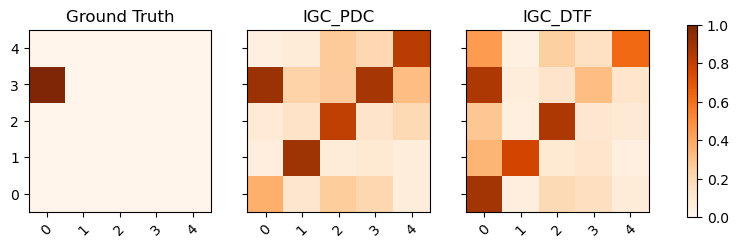

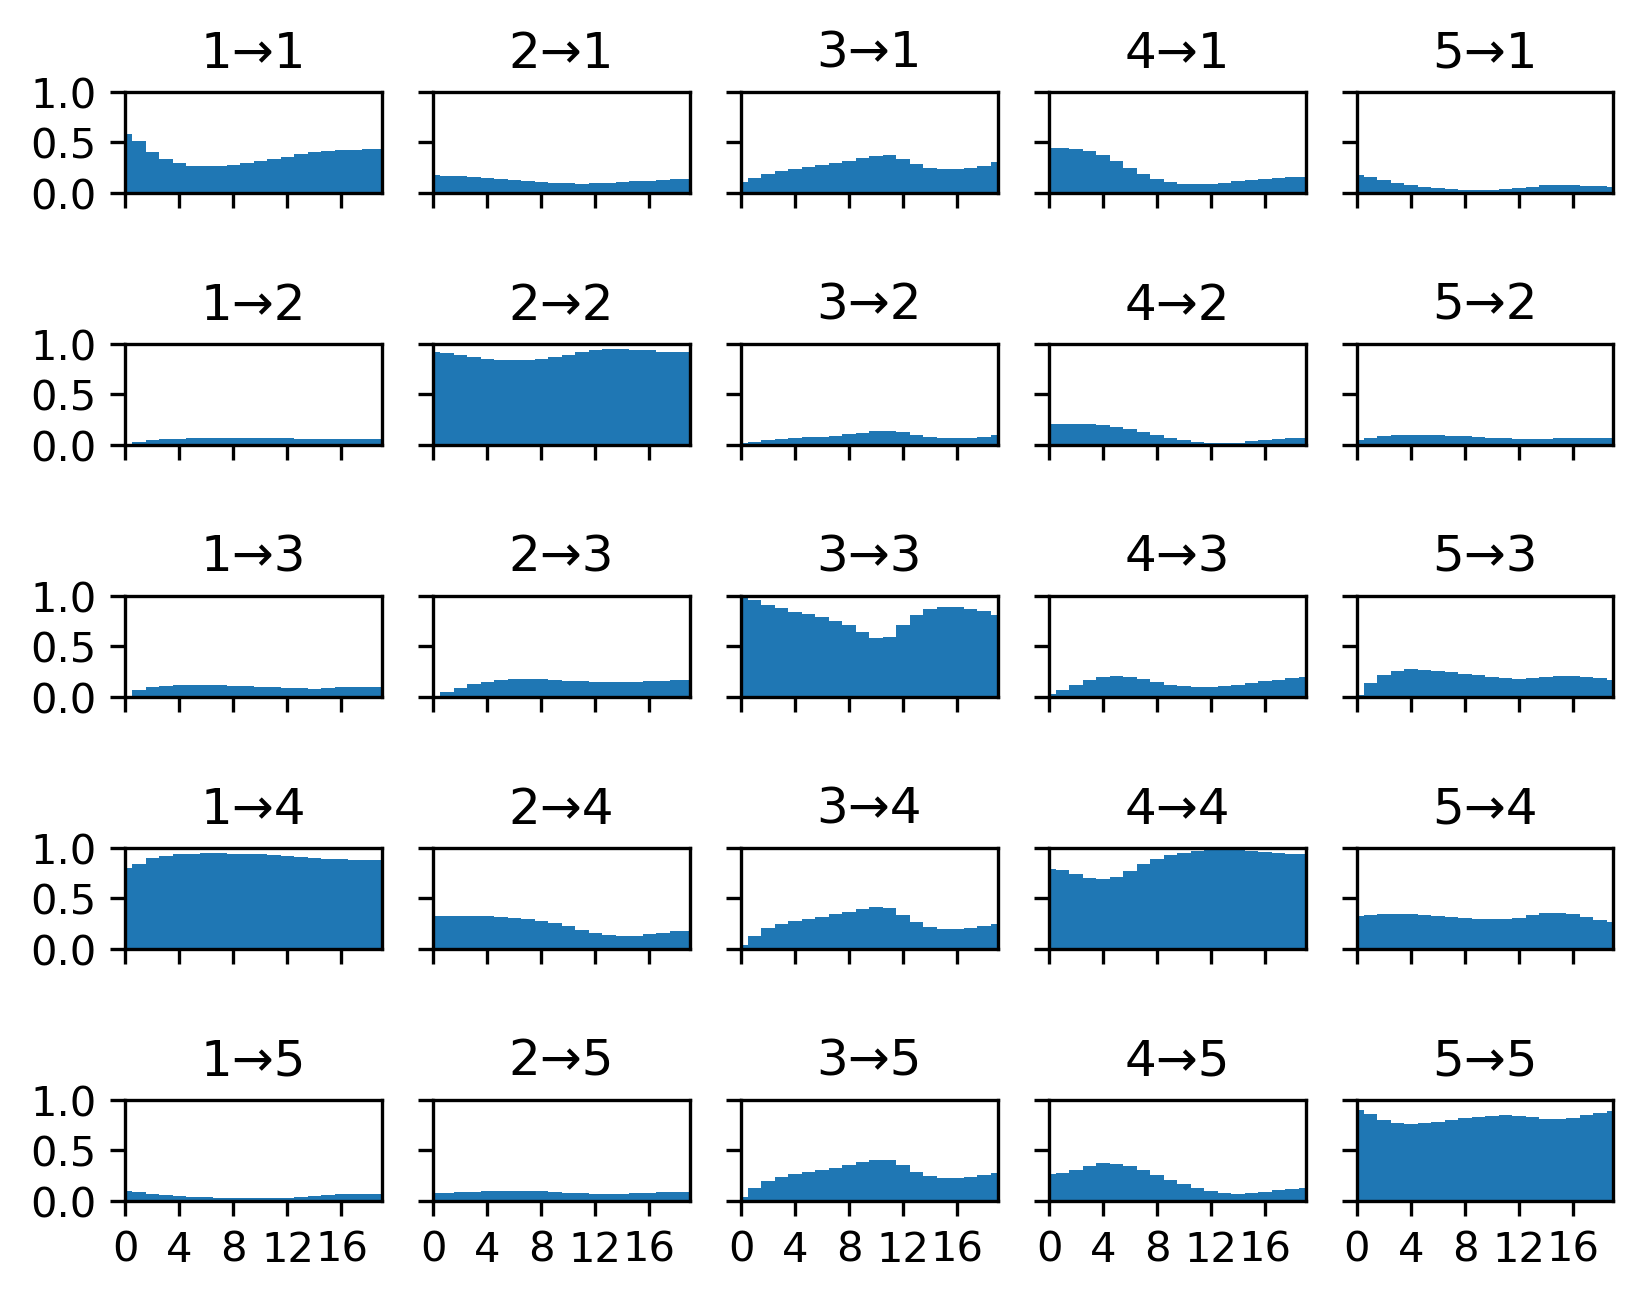

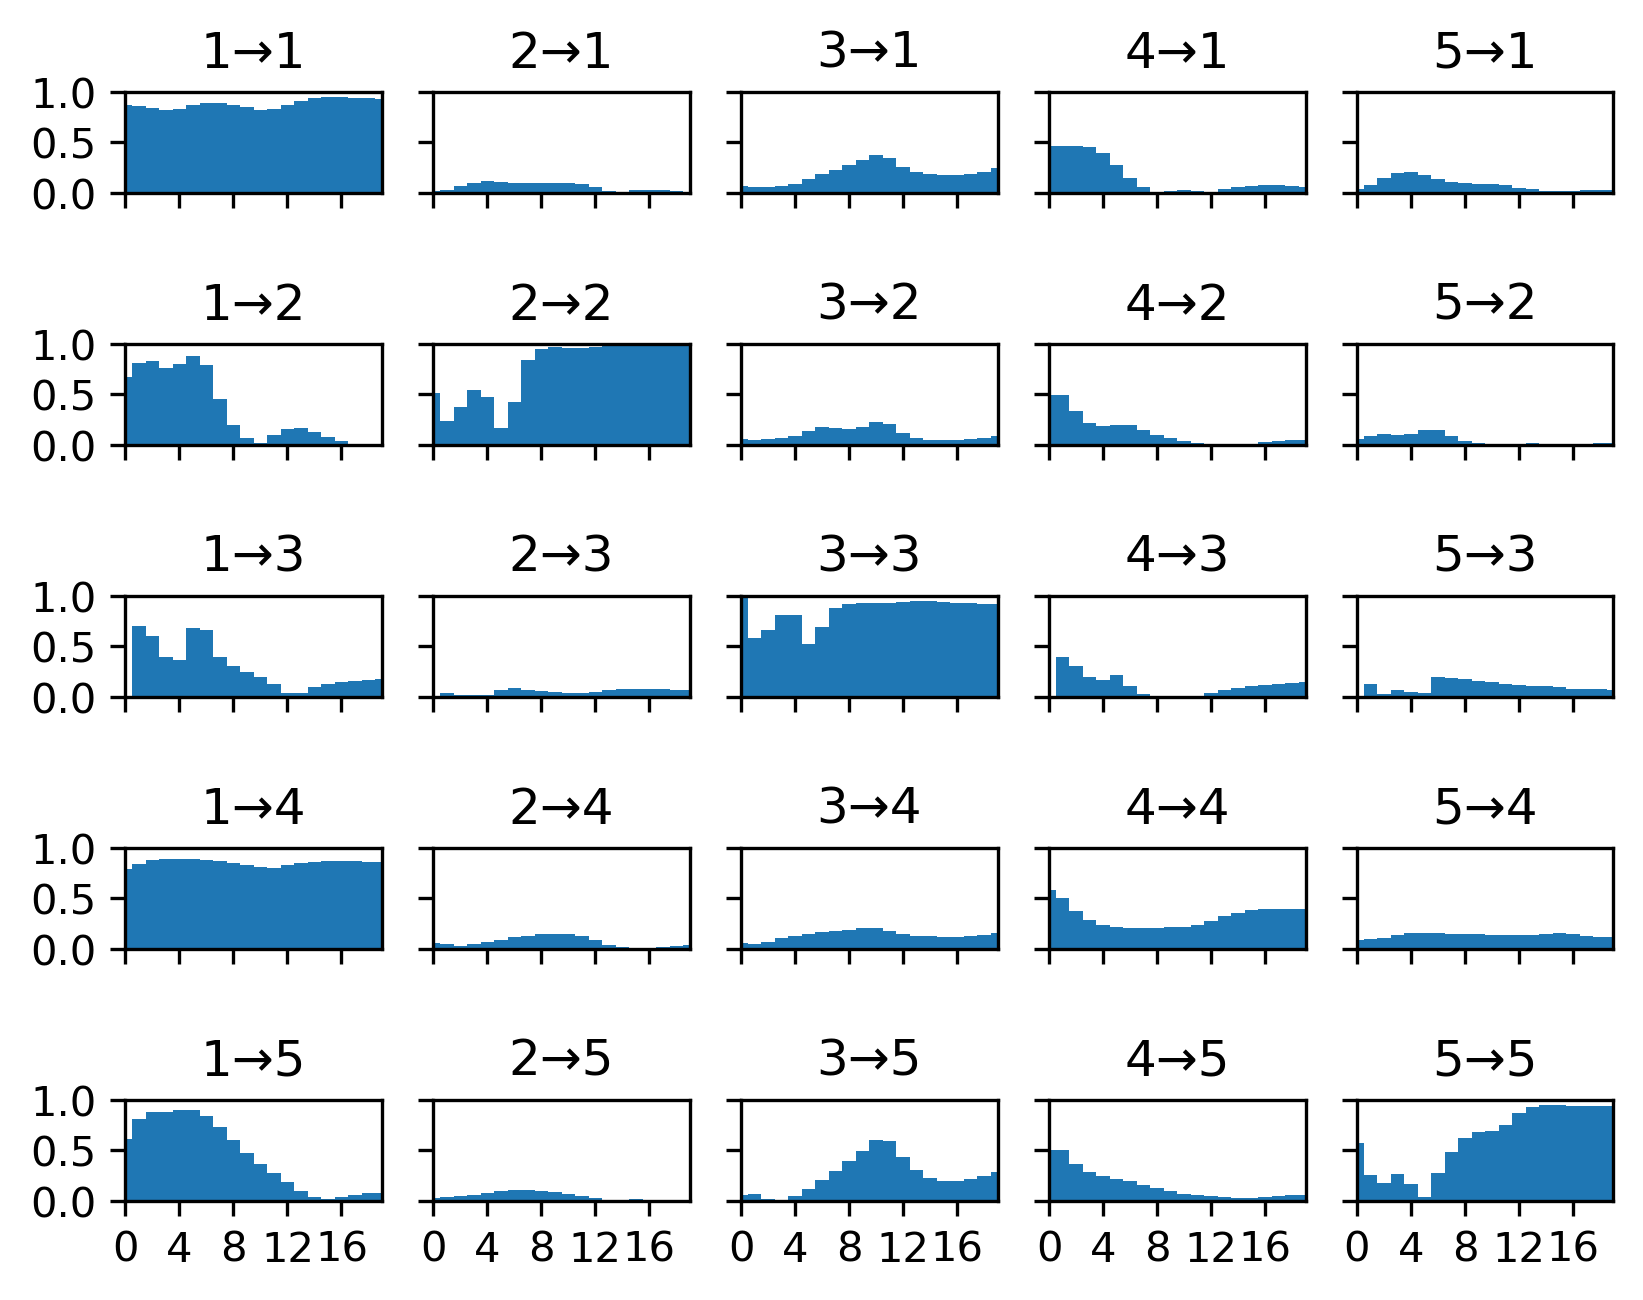

In [23]:
#igc, cl, igc_t, igc_p, igc_f, foi = ig_connectivity(x, model=model, nrs=2, device=device)
igc_pdc, igc_dtf, _,_,_, foi = IGC.ig_connectivity(x, model=model, stat='DTF', nrs=0, device=device)
IGC.display_connectivity([groundtruth, igc_pdc[:,:5,:5].mean(0), igc_dtf[:,:5,:5].mean(0)], 
                         title=['Ground Truth', 'IGC_PDC', 'IGC_DTF'], 
                         labels=['0','1','2','3','4'], vmax=1)
fig=IGC.display_conn_spectrum(igc_pdc[:,:5,:5])
fig=IGC.display_conn_spectrum(igc_dtf[:,:5,:5])